In [1]:
import os
import re
import ast
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from tqdm import tqdm
from umap import UMAP
from torch.nn import CosineSimilarity
from scipy.stats import pointbiserialr
from datasets import load_dataset, load_from_disk
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel

tqdm.pandas()

# Seaborn settings
sns.set_context("notebook")
sns.set_palette("colorblind")
aug_regex = re.compile(r"<aug>(.*?)</aug>", re.DOTALL)

# Matplotlib settings
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif",
  # "font.serif": ["Palatino"],
  "font.serif": "cm",
  "font.size": 16,
})


/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# display full dataframes
pd.set_option("display.max_columns", None)

In [4]:
# plotting constants
TITLE_FONT_SIZE = 16
WSPACE = 0.3
FIGURE_HEIGHT = 3
LINE_WIDTH = 2
FIG_SIZE = 4
MARKER_SIZE = 8

In [5]:

inference_logs = load_from_disk("data/combined_dataset")
list(inference_logs.keys())

['BOSS_Sentiment_ID_BERT_Insert',
 'BOSS_Sentiment_ID_BERT_Substitute',
 'BOSS_Sentiment_ID_BERT_Translate',
 'BOSS_Sentiment_ID_BERT_Paraphrase',
 'BOSS_Sentiment_ID_BERT_ICR',
 'BOSS_Sentiment_ID_T5_Insert',
 'BOSS_Sentiment_ID_T5_Substitute',
 'BOSS_Sentiment_ID_T5_Translate',
 'BOSS_Sentiment_ID_T5_Paraphrase',
 'BOSS_Sentiment_ID_T5_ICR',
 'BOSS_Sentiment_ID_Falcon_Insert',
 'BOSS_Sentiment_ID_Falcon_Substitute',
 'BOSS_Sentiment_ID_Falcon_Translate',
 'BOSS_Sentiment_ID_Falcon_Paraphrase',
 'BOSS_Sentiment_ID_Falcon_ICR',
 'BOSS_Sentiment_SST5_BERT_Insert',
 'BOSS_Sentiment_SST5_BERT_Substitute',
 'BOSS_Sentiment_SST5_BERT_Translate',
 'BOSS_Sentiment_SST5_BERT_Paraphrase',
 'BOSS_Sentiment_SST5_BERT_ICR',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Insert',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Substitute',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Translate',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Paraphrase',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_ICR',
 'BOSS_Sen

In [6]:
def parse_task_name(split_name):
    return "Sentiment" if "Sentiment" in split_name else "Toxicity" if "Toxicity" in split_name else "News"

def parse_distribution(split_name):
    return split_name.split("_")[-3]

def parse_model(split_name):
    return split_name.split("_")[-2]

def parse_tta_method(split_name):
    return split_name.split("_")[-1]

## No TTA Baselines

In [7]:
no_tta_accuracies = {}
for split_name in tqdm(inference_logs):
    split_frame = inference_logs[split_name].to_pandas()
    split_no_tta_accuracy = classification_report(split_frame["label"], split_frame["original_predicted_class"], output_dict=True)["accuracy"]
    no_tta_accuracies[split_name] = split_no_tta_accuracy

no_tta_accuracies

  3%|▎         | 10/318 [00:00<00:27, 11.22it/s]/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

{'BOSS_Sentiment_ID_BERT_Insert': 0.9037888134896155,
 'BOSS_Sentiment_ID_BERT_Substitute': 0.9037888134896155,
 'BOSS_Sentiment_ID_BERT_Translate': 0.9037888134896155,
 'BOSS_Sentiment_ID_BERT_Paraphrase': 0.9037888134896155,
 'BOSS_Sentiment_ID_BERT_ICR': 0.9037888134896155,
 'BOSS_Sentiment_ID_T5_Insert': 0.9011412708204812,
 'BOSS_Sentiment_ID_T5_Substitute': 0.9011412708204812,
 'BOSS_Sentiment_ID_T5_Translate': 0.9011412708204812,
 'BOSS_Sentiment_ID_T5_Paraphrase': 0.9011412708204812,
 'BOSS_Sentiment_ID_T5_ICR': 0.9011412708204812,
 'BOSS_Sentiment_ID_Falcon_Insert': 0.9049712111865104,
 'BOSS_Sentiment_ID_Falcon_Substitute': 0.9049712111865104,
 'BOSS_Sentiment_ID_Falcon_Translate': 0.9049712111865104,
 'BOSS_Sentiment_ID_Falcon_Paraphrase': 0.9049712111865104,
 'BOSS_Sentiment_ID_Falcon_ICR': 0.9049712111865104,
 'BOSS_Sentiment_SST5_BERT_Insert': 0.6847014925373134,
 'BOSS_Sentiment_SST5_BERT_Substitute': 0.6847014925373134,
 'BOSS_Sentiment_SST5_BERT_Translate': 0.684701492

## Analyze Main Results

In [8]:
main_results_bert_splits = [split for split in inference_logs.keys() if "Ablate" not in split]
datasets = ["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]
split_data = {}

for task_name in datasets:
    if task_name not in split_data:
        split_data[task_name] = {}

    for split in tqdm(main_results_bert_splits):
        if task_name in split:
            distribution = split.split("_")[-3]
            model = split.split("_")[-2]
            tta_method = split.split("_")[-1]
            baseline_accuracy = classification_report(inference_logs[split]["label"], inference_logs[split]["original_predicted_class"], output_dict=True)["accuracy"]
            tta_accuracy = classification_report(inference_logs[split]["label"], inference_logs[split]["tta_predicted_class"], output_dict=True)["accuracy"]
            accuracy_delta = tta_accuracy - baseline_accuracy

            if model not in split_data[task_name]:
                split_data[task_name][model] = {}

            if tta_method not in split_data[task_name][model]:
                split_data[task_name][model][tta_method] = {}

            split_data[task_name][model][tta_method][distribution] = {
                "distribution": distribution,
                "model": model,
                "tta_method": tta_method,
                "baseline_accuracy": baseline_accuracy,
                "tta_accuracy": tta_accuracy,
                "accuracy_delta": accuracy_delta
            }

    # get the Accuracy Gain for each method excluding ID
    for model_name in split_data[task_name]:
        for tta_method in split_data[task_name][model_name]:
            accuracy_deltas = []
            baseline_accuracies = []
            for distribution in split_data[task_name][model_name][tta_method]:
                if distribution == "ID":
                    continue

                current_tta_result = split_data[task_name][model_name][tta_method][distribution]
                accuracy_deltas.append(current_tta_result["accuracy_delta"])
                baseline_accuracies.append(current_tta_result["baseline_accuracy"])

            split_data[task_name][model_name][tta_method]["mean_accuracy_delta"] = np.mean(accuracy_deltas)
            split_data[task_name][model_name][tta_method]["mean_baseline_accuracy"] = np.mean(baseline_accuracies)

print(json.dumps(split_data, indent=4))

  1%|▏         | 2/143 [00:00<00:09, 15.24it/s]/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

{
    "BOSS_Sentiment": {
        "BERT": {
            "Insert": {
                "ID": {
                    "distribution": "ID",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.9037888134896155,
                    "tta_accuracy": 0.9048169853999589,
                    "accuracy_delta": 0.001028171910343434
                },
                "SST5": {
                    "distribution": "SST5",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.6847014925373134,
                    "tta_accuracy": 0.683768656716418,
                    "accuracy_delta": -0.0009328358208954279
                },
                "SemEval": {
                    "distribution": "SemEval",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.4497187742435997,
                    "tta_

In [9]:
detailed_results_records = []
for task_name in split_data:
    for model_name in split_data[task_name]:
        for tta_method in split_data[task_name][model_name]:
            for dist in [dist for dist in split_data[task_name][model_name][tta_method] if not dist.startswith("mean")]:

                perf_record = split_data[task_name][model_name][tta_method][dist]
                detailed_results_records.append({
                    "task": task_name,
                    "model": model_name,
                    "tta_method": tta_method,
                    "distribution": dist,
                    # "baseline_accuracy": perf_record["baseline_accuracy"] * 100,
                    # "tta_accuracy": perf_record["tta_accuracy"] * 100,
                    "accuracy_delta": round(perf_record["accuracy_delta"] * 100, 2),
                })

detailed_results_frame = pd.DataFrame(detailed_results_records)
for task_name in split_data:
    task_frame = detailed_results_frame[detailed_results_frame["task"] == task_name]
    display(task_frame.groupby(["task", "model", "distribution", "tta_method", ]).mean().T)

detailed_results_frame.groupby(["task", "model", "distribution", "tta_method", ]).mean().to_csv("data/detailed_results.csv")

task           BOSS_Sentiment                                               \
model                    BERT                                                
distribution         Dynasent                                           ID   
tta_method                ICR Insert Paraphrase Substitute Translate   ICR   
accuracy_delta            5.0  -0.14       2.64      -0.09      0.46  0.47   

task                                                                          \
model                                                                          
distribution                                          SST5                     
tta_method     Insert Paraphrase Substitute Translate  ICR Insert Paraphrase   
accuracy_delta    0.1       0.16      -0.42     -1.33  5.5  -0.09       2.52   

task                                                                      \
model                                                                      
distribution                        SemEval                                
tta_method     Substitute Translate     ICR Insert Paraphrase Substitute   
accuracy_delta      -0.65      0.65    4.08  -0.15       2.66      -0.06   

task                                                                      \
model                      Falcon                                          
distribution             Dynasent                                          
tta_method     Translate      ICR Insert Paraphrase Substitute Translate   
accuracy_delta      0.53    -2.57  -1.37      -1.64      -1.09     -1.55   

task                                                                      \
model                                                                      
distribution      ID                                         SST5          
tta_method       ICR Insert Paraphrase Substitute Translate   ICR Insert   
accuracy_delta -0.15  -1.08      -0.15      -3.92     -3.36 -5.41  -1.49   

task                                                                      \
model                                                                      
distribution                                   SemEval                     
tta_method     Paraphrase Substitute Translate     ICR Insert Paraphrase   
accuracy_delta      -2.15      -4.66     -3.82   -0.92   0.41       0.04   

task                                                                       \
model                                     T5                                
distribution                        Dynasent                                
tta_method     Substitute Translate      ICR Insert Paraphrase Substitute   
accuracy_delta      -2.94     -1.18     4.38  -1.76       2.62      -1.92   

task                                                                         \
model                                                                         
distribution                ID                                         SST5   
tta_method     Translate   ICR Insert Paraphrase Substitute Translate   ICR   
accuracy_delta     -0.51  0.67  -1.71      -0.22      -4.34     -2.89  0.09   

task                                                                  \
model                                                                  
distribution                                          SemEval          
tta_method     Insert Paraphrase Substitute Translate     ICR Insert   
accuracy_delta  -3.54       0.19      -5.32     -1.96    1.06  -0.63   

task                                            
model                                           
distribution                                    
tta_method     Paraphrase Substitute Translate  
accuracy_delta       0.73      -1.51     -0.92

task           BOSS_Toxicity                                               \
model                   BERT                                                
distribution        AdvCivil                                           ID   
tta_method               ICR Insert Paraphrase Substitute Translate   ICR   
accuracy_delta         20.27  -3.28      30.83       -1.7     24.15  2.98   

task                                                                       \
model                                                                       
distribution                                          ImplicitHate          
tta_method     Insert Paraphrase Substitute Translate          ICR Insert   
accuracy_delta   0.79       2.12       1.44      1.18         1.21   0.33   

task                                                                      \
model                                                                      
distribution                                   Toxigen                     
tta_method     Paraphrase Substitute Translate     ICR Insert Paraphrase   
accuracy_delta       0.44       1.35     -0.19   -0.95   0.53       0.11   

task                                                                       \
model                                 Falcon                                
distribution                        AdvCivil                                
tta_method     Substitute Translate      ICR Insert Paraphrase Substitute   
accuracy_delta      -1.27     -0.74    -2.43    0.0      -1.46        0.0   

task                                                                    \
model                                                                    
distribution                 ID            ImplicitHate Toxigen          
tta_method     Translate Insert Substitute       Insert     ICR Insert   
accuracy_delta       0.0  -0.07       2.98        -1.52     0.0  -2.54   

task                                                                       \
model                                                T5                     
distribution                                   AdvCivil                     
tta_method     Paraphrase Substitute Translate      ICR Insert Paraphrase   
accuracy_delta       0.95      -1.06      0.74    13.23  -4.98      23.54   

task                                                                   \
model                                                                   
distribution                          ID                                
tta_method     Substitute Translate  ICR Insert Paraphrase Substitute   
accuracy_delta      -4.49     12.62  1.3   0.35       0.75       0.76   

task                                                                          \
model                                                                          
distribution             ImplicitHate                                          
tta_method     Translate          ICR Insert Paraphrase Substitute Translate   
accuracy_delta      0.08         1.12   0.68       0.42       1.39     -0.04   

task                                                           
model                                                          
distribution   Toxigen                                         
tta_method         ICR Insert Paraphrase Substitute Translate  
accuracy_delta    0.74   0.21       0.85      -0.53      1.38

task           AgNewsTweets                                                \
model                  BERT                                                 
distribution             ID                                        Tweets   
tta_method              ICR Insert Paraphrase Substitute Translate    ICR   
accuracy_delta         -1.3   0.07      -1.11       0.03     -0.91   1.18   

task                                                                 \
model                                                 Falcon          
distribution                                              ID          
tta_method     Insert Paraphrase Substitute Translate    ICR Insert   
accuracy_delta   0.28       0.54       0.29      0.25  -0.83  -3.46   

task                                                                     \
model                                                                     
distribution                                   Tweets                     
tta_method     Paraphrase Substitute Translate    ICR Insert Paraphrase   
accuracy_delta      -1.53      -3.96     -0.18   2.16  -1.04       1.99   

task                                                                    \
model                                  T5                                
distribution                           ID                                
tta_method     Substitute Translate   ICR Insert Paraphrase Substitute   
accuracy_delta      -1.12      0.36 -2.88  -2.64      -2.82      -2.96   

task                                                                    
model                                                                   
distribution             Tweets                                         
tta_method     Translate    ICR Insert Paraphrase Substitute Translate  
accuracy_delta     -2.17   1.51   0.58       1.16       0.12      0.03

In [10]:
# create dataframe where there is a column for dataset, model, id_accuracy_delta, and mean_accuracy_delta
records = []

for task_name in tqdm(split_data):
    for model_name in split_data[task_name]:
        for tta_method in split_data[task_name][model_name]:
            current_tta_result = split_data[task_name][model_name][tta_method]
            records.append({
                "dataset": task_name,
                "model": model_name,
                "tta_method": tta_method,
                "id_accuracy_delta": current_tta_result["ID"]["accuracy_delta"] * 100 if "ID" in current_tta_result else None,
                "ood_mean_accuracy_delta": current_tta_result["mean_accuracy_delta"] * 100,
                "ood_mean_baseline_accuracy": current_tta_result["mean_baseline_accuracy"] * 100,
            })


main_results_frame = pd.DataFrame(records)
for model in split_data[task_name]:
    display(model)
    display(main_results_frame[main_results_frame["model"] == model].drop(columns="model").groupby(["dataset", "tta_method"]).mean().T)


100%|██████████| 3/3 [00:00<00:00, 49932.19it/s]


'BERT'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -1.302632   0.065789  -1.105263   0.026316   
ood_mean_accuracy_delta        1.184211   0.276316   0.539474   0.289474   
ood_mean_baseline_accuracy    88.565789  88.565789  88.565789  88.565789   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -0.907895       0.472959   0.102817   0.156796   
ood_mean_accuracy_delta      0.250000       4.860502  -0.127494   2.604881   
ood_mean_baseline_accuracy  88.565789      52.050120  52.050120  52.050120   

dataset                                          BOSS_Toxicity             \
tta_method                 Substitute  Translate           ICR     Insert   
id_accuracy_delta           -0.418980  -1.328912      2.984998   0.789149   
ood_mean_accuracy_delta     -0.269537   0.548153      6.841343  -0.807051   
ood_mean_baseline_accuracy  52.050120  52.050120     53.907864  53.907864   

dataset                                                      
tta_method                 Paraphrase Substitute  Translate  
id_accuracy_delta            2.119811   1.437526   1.178586  
ood_mean_accuracy_delta     10.456264  -0.538489   7.739362  
ood_mean_baseline_accuracy  53.907864  53.907864  53.907864

'T5'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -2.881579  -2.644737  -2.815789  -2.960526   
ood_mean_accuracy_delta        1.513158   0.578947   1.157895   0.118421   
ood_mean_baseline_accuracy    89.013158  89.013158  89.013158  89.013158   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -2.171053       0.665741  -1.711906  -0.215916   
ood_mean_accuracy_delta      0.026316       1.843384  -1.976507   1.176539   
ood_mean_baseline_accuracy  89.013158      57.988354  57.988354  57.988354   

dataset                                          BOSS_Toxicity             \
tta_method                 Substitute  Translate           ICR     Insert   
id_accuracy_delta           -4.336315  -2.894304      1.298808   0.351418   
ood_mean_accuracy_delta     -2.917087  -1.129824      5.030552  -1.361387   
ood_mean_baseline_accuracy  57.988354  57.988354     58.857741  58.857741   

dataset                                                      
tta_method                 Paraphrase Substitute  Translate  
id_accuracy_delta            0.750103   0.757296   0.077065  
ood_mean_accuracy_delta      8.271599  -1.209320   4.652193  
ood_mean_baseline_accuracy  58.857741  58.857741  58.857741

'Falcon'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -0.828947  -3.460526  -1.526316  -3.960526   
ood_mean_accuracy_delta        2.157895  -1.039474   1.986842  -1.118421   
ood_mean_baseline_accuracy    26.000000  26.000000  26.000000  26.000000   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -0.184211      -0.149085  -1.082151  -0.149085   
ood_mean_accuracy_delta      0.355263      -2.967050  -0.816995  -1.248467   
ood_mean_baseline_accuracy  26.000000      47.166769  47.166769  47.166769   

dataset                                          BOSS_Toxicity             \
tta_method                 Substitute  Translate           ICR     Insert   
id_accuracy_delta           -3.919905  -3.359552           NaN  -0.065762   
ood_mean_accuracy_delta     -2.898438  -2.186213     -1.213592  -1.353355   
ood_mean_baseline_accuracy  47.166769  47.166769     66.624157  58.798476   

dataset                                                      
tta_method                 Paraphrase Substitute  Translate  
id_accuracy_delta                 NaN   2.982943        NaN  
ood_mean_accuracy_delta     -0.251460  -0.529661   0.370763  
ood_mean_baseline_accuracy  66.624157  66.624157  66.624157

## Dataset Stats

In [11]:
split_label_value_counts = {}

for split_name in main_results_bert_splits:
    if "BERT" not in split_name:
        continue

    set_name = split_name.split("_BERT")[0]
    if set_name in split_label_value_counts:
        continue

    split_frame = inference_logs[split_name].to_pandas()
    label_counts = split_frame["label"].value_counts().to_dict()
    label_counts[-1] = len(split_frame)
    label_counts = {k: label_counts[k] for k in sorted(label_counts)}
    split_label_value_counts[set_name] = label_counts

pd.DataFrame(split_label_value_counts)

,BOSS_Sentiment_ID,BOSS_Sentiment_SST5,BOSS_Sentiment_SemEval,BOSS_Sentiment_Dynasent,BOSS_Toxicity_ID,BOSS_Toxicity_Toxigen,BOSS_Toxicity_ImplicitHate,BOSS_Toxicity_AdvCivil,AgNewsTweets_ID,AgNewsTweets_Tweets
-1,38904.0,1072.0,20624.0,4320.0,97320.0,944.0,21480.0,824.0,7600,7600
0,2181.0,282.0,3229.0,1440.0,89543.0,544.0,13291.0,152.0,1900,1900
1,32862.0,400.0,7059.0,1440.0,7777.0,400.0,8189.0,672.0,1900,1900
2,3861.0,390.0,10336.0,1440.0,NaN,NaN,NaN,NaN,1900,1900
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900,1900


# Analyze Across Dataset Sizes

In [12]:
all_splits = [split for split in inference_logs.keys() if "Ablate_Data" in split]
datasets = set([("_".join(split.split("_")[:2]).replace("_Ablate", "")) for split in all_splits if "Ablate_Data" in split])
results = {}
# print(datasets)

for task_name in datasets:
    results[task_name] = {}

    for split_name in tqdm(all_splits, desc=task_name):
        if task_name in split_name:
            data_count = int(split_name.split("_")[-2].replace("BERT", ""))
            tta_method = split_name.split("_")[-1]
            shift_name = split_name.split("_")[-3]
            # print(dataset, data_count, tta_method, shift_name)

            baseline_accuracy = classification_report(inference_logs[split_name]["label"], inference_logs[split_name]["original_predicted_class"], output_dict=True)["accuracy"]
            tta_accuracy = classification_report(inference_logs[split_name]["label"], inference_logs[split_name]["tta_predicted_class"], output_dict=True)["accuracy"]

            if task_name not in results:
                results[task_name] = {}
            if data_count not in results[task_name]:
                results[task_name][data_count] = {}
            if tta_method not in results[task_name][data_count]:
                results[task_name][data_count][tta_method] = {}
            if shift_name not in results[task_name][data_count][tta_method]:
                results[task_name][data_count][tta_method][shift_name] = {}

            results[task_name][data_count][tta_method][shift_name] = {
                "method": tta_method,
                "baseline_accuracy": baseline_accuracy,
                "tta_accuracy": tta_accuracy,
                "baseline_delta": tta_accuracy - baseline_accuracy,
            }

            # inference_frames[task_name] = inference_logs[split].to_pandas()
            # break

print(json.dumps(results, indent=4))

BOSS_Toxicity: 100%|██████████| 175/175 [00:01<00:00, 139.77it/s]

{
    "AgNewsTweets": {
        "4800": {
            "Insert": {
                "Tweets": {
                    "method": "Insert",
                    "baseline_accuracy": 0.8864473684210527,
                    "tta_accuracy": 0.8893421052631579,
                    "baseline_delta": 0.0028947368421052833
                }
            },
            "Substitute": {
                "Tweets": {
                    "method": "Substitute",
                    "baseline_accuracy": 0.8864473684210527,
                    "tta_accuracy": 0.888421052631579,
                    "baseline_delta": 0.0019736842105263497
                }
            },
            "Translate": {
                "Tweets": {
                    "method": "Translate",
                    "baseline_accuracy": 0.8864473684210527,
                    "tta_accuracy": 0.8893421052631579,
                    "baseline_delta": 0.0028947368421052833
                }
            },
            "Paraphrase": {
           

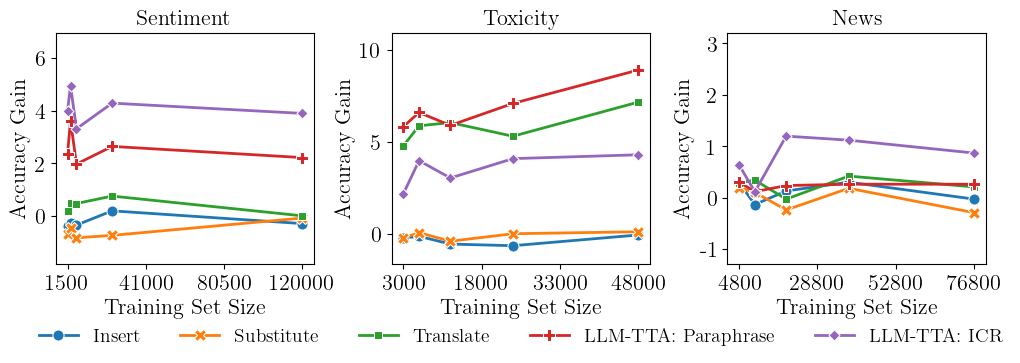

In [13]:
formatted_method_names = {
    "Insert": "Insert",
    "Substitute": "Substitute",
    "Translate": "Translate",
    "Paraphrase": "LLM-TTA: Paraphrase",
    "ICR": "LLM-TTA: ICR",
}

method_avg_delta = {}
for task_name in results:
    for data_count in results[task_name]:
        tta_perf_deltas = {}
        for tta_method in results[task_name][data_count]:
            for ood_shift in results[task_name][data_count][tta_method]:
                if tta_method not in tta_perf_deltas:
                    tta_perf_deltas[tta_method] = []

                shift_method_perf_deta = results[task_name][data_count][tta_method][ood_shift]["baseline_delta"]
                tta_perf_deltas[tta_method].append(shift_method_perf_deta)

        if task_name not in method_avg_delta:
            method_avg_delta[task_name] = {}

        method_avg_delta[task_name][data_count] = { tta_method: np.mean(tta_perf_deltas[tta_method]) for tta_method in tta_perf_deltas }
        baseline = np.mean([method_avg_delta[task_name][data_count]["Insert"], method_avg_delta[task_name][data_count]["Substitute"], method_avg_delta[task_name][data_count]["Translate"]])
        method_avg_delta[task_name][data_count]["Conventional Augmentation"] = baseline

# display(method_avg_delta)

pandas_form = {task_name: {} for task_name in results}
for task_name in pandas_form:
    for data_count in method_avg_delta[task_name]:
        for tta_method in ["Insert", "Substitute", "Translate", "Paraphrase", "ICR"]:
            if data_count not in pandas_form[task_name]:
                pandas_form[task_name][data_count] = []

            pandas_form[task_name][data_count].append({
                "data_count": data_count,
                "tta_method": formatted_method_names[tta_method],
                "avg_delta": method_avg_delta[task_name][data_count][tta_method],
            })


fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
for i, task_name in enumerate(["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]):
    df = pd.concat([pd.DataFrame(pandas_form[task_name][data_count]) for data_count in pandas_form[task_name]])
    sns.lineplot(
        data=df,
        x="data_count",
        y="avg_delta",
        hue="tta_method",
        ax=axes[i],
        linewidth=LINE_WIDTH,
        markersize=MARKER_SIZE,
        style="tta_method",
        dashes=False,
        markers=True,
    )

    # set x label to Training Set Size
    axes[i].set_xlabel("Training Set Size")

    # set y label to Mean Absolute Accuracy Delta
    axes[i].set_ylabel("Accuracy Gain")

    # make the y axis percents that go to the hundreds place
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # standardize the y axis between the min and max of df
    axes[i].set_ylim(df["avg_delta"].min() - 0.01, df["avg_delta"].max() + 0.02)

    title_text = {
        "BOSS_Sentiment": "Sentiment",
        "BOSS_Toxicity": "Toxicity",
        "AgNewsTweets": "News",
    }
    axes[i].set_title(title_text[task_name], fontsize=TITLE_FONT_SIZE)

    # se legend to the bottom left
    axes[i].legend(loc="lower right")

    # x axis ticks are five equally spaced ticks between the min and max of the x axis
    axes[i].set_xticks(np.linspace(df["data_count"].min(), df["data_count"].max(), 4))

    # remove leegnd in not middle plot
    if i != 1:
        axes[i].get_legend().remove()
    else:
        # center below plot with no frame
        axes[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=5, frameon=False, fontsize=14)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)

if not os.path.exists("figures/"):
    os.makedirs("figures/")
fig.savefig("figures/method_analysis_data_ablation.png", bbox_inches="tight")

# OOD Analysis

In [14]:
ood_sentiment_icr_data = None
ood_toxicity_icr_data = None
ood_tweets_icr_data = None
for split_name in tqdm(inference_logs.keys()):
    current_frame = inference_logs[split_name].to_pandas()
    current_frame["dataset"] = split_name

    if "Sentiment" in split_name and "ICR" in split_name and "ID" not in split_name and "BERT" in split_name and "Ablate" not in split_name:
        if ood_sentiment_icr_data is None:
            ood_sentiment_icr_data = current_frame
        else:
            ood_sentiment_icr_data = pd.concat([ood_sentiment_icr_data, current_frame])

    if "Toxicity" in split_name and "ICR" in split_name and "ID" not in split_name and "BERT" in split_name and "Ablate" not in split_name:
        if ood_toxicity_icr_data is None:
            ood_toxicity_icr_data = current_frame
        else:
            ood_toxicity_icr_data = pd.concat([ood_toxicity_icr_data, current_frame])

    if "Tweets" in split_name and "ICR" in split_name and "ID" not in split_name and "BERT" in split_name and "Ablate" not in split_name:
        if ood_tweets_icr_data is None:
            ood_tweets_icr_data = current_frame
        else:
            ood_tweets_icr_data = pd.concat([ood_tweets_icr_data, current_frame])


display(ood_sentiment_icr_data.value_counts("dataset"))
display(ood_toxicity_icr_data.value_counts("dataset"))
display(ood_tweets_icr_data.value_counts("dataset"))
assert len(ood_sentiment_icr_data.value_counts("dataset")) == 3
assert len(ood_toxicity_icr_data.value_counts("dataset")) == 3
assert len(ood_tweets_icr_data.value_counts("dataset")) == 1

100%|██████████| 318/318 [00:07<00:00, 41.42it/s]


dataset
BOSS_Sentiment_SemEval_BERT_ICR     20624
BOSS_Sentiment_Dynasent_BERT_ICR     4320
BOSS_Sentiment_SST5_BERT_ICR         1072
Name: count, dtype: int64

dataset
BOSS_Toxicity_ImplicitHate_BERT_ICR    21480
BOSS_Toxicity_Toxigen_BERT_ICR           944
BOSS_Toxicity_AdvCivil_BERT_ICR          824
Name: count, dtype: int64

dataset
AgNewsTweets_Tweets_BERT_ICR    7600
Name: count, dtype: int64

## Aggregation Ablation Study

In [15]:
def aggregate_predictions(predictions, num_predictions, use_test_input):
    try:
        ablation_preds = predictions[:num_predictions]
        if use_test_input:
            ablation_preds = ablation_preds.tolist() + [predictions[-1]]
        
        mean_distribution = np.mean(ablation_preds, axis=0) if len(ablation_preds) > 1 else ablation_preds[0]
        predicted_class = np.argmax(mean_distribution)
        return predicted_class
    except:
        return -1


perf_records = []
inference_ablation_splits = [split for split in inference_logs.keys() if "Ablate" not in split and "BERT" in split]
for split_name in tqdm(inference_ablation_splits):
    dataset = parse_task_name(split_name)
    distribution = parse_distribution(split_name)
    model = parse_model(split_name)
    method = parse_tta_method(split_name)

    current_frame = inference_logs[split_name].to_pandas()
    for use_source in [False, True]:
        for num_augmentations in range(1, 5):
            judgments = current_frame["tta_all_class_probs"].apply(lambda x: aggregate_predictions(x, num_augmentations, use_source))
            accuracy = classification_report(current_frame["label"], judgments, output_dict=True)["accuracy"]
            perf_records.append({
                "dataset": dataset,
                "distribution": distribution,
                "model": model,
                "method": formatted_method_names[method],
                "use_source": use_source,
                "num_augmentations": num_augmentations,
                "accuracy": accuracy,
                "delta": accuracy - no_tta_accuracies[split_name],
            })



  6%|▌         | 3/50 [00:05<01:19,  1.69s/it]/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

In [ ]:
aggregation_ablation_frame = pd.DataFrame(perf_records)

# select where distribution != ID
aggregation_ablation_frame = aggregation_ablation_frame[aggregation_ablation_frame["distribution"] != "ID"]

# set method to TTA if not Paraphrase or ICR and LLM-TTA if Paraphrase or ICR
# aggregation_ablation_frame["method"] = aggregation_ablation_frame["method"].apply(lambda x: "TTA" if x not in ["Paraphrase", "ICR"] else "LLM-TTA")

# for tta_method in ["Conventional Augmentation", "Paraphrase", "ICR"]:
# aggregation_ablation_frame["method"] = aggregation_ablation_frame["method"].apply(lambda x: "ICR" if "ICR" in x else "Paraphrase" if "Paraphrase" in x else "Conventional Augmentation")

# create three figures, one for Sentiment, Toxicity, and News

fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
for index, task_name in enumerate(["Sentiment", "Toxicity", "News"]):
    # get the current task frame
    current_frame = aggregation_ablation_frame[aggregation_ablation_frame["dataset"] == task_name]

    # where use_source is True
    current_frame_source = current_frame[current_frame["use_source"] == True]

    # plot the current task frame
    sns.lineplot(
        data=current_frame,
        x="num_augmentations",
        y="delta",
        hue="method",
        ax=axes[index],
        linewidth=LINE_WIDTH,
        ci=None,
        style="method",
        dashes=False,
        markers=True,
        markersize=MARKER_SIZE)

    # set x label to Number of Augmentations
    axes[index].set_xlabel("Number of Augmentations")

    # set y label to Accuracy
    axes[index].set_ylabel("Accuracy Gain")

    # make the y axis percents that go to the hundreds place
    axes[index].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # set title to Sentiment, Toxicity, or News
    axes[index].set_title(task_name, fontsize=TITLE_FONT_SIZE)

    # se legend to the bottom left
    axes[index].legend(loc="lower right")

    # x axis ticks are five equally spaced ticks between the min and max of the x axis
    axes[index].set_xticks(np.linspace(current_frame["num_augmentations"].min(), current_frame["num_augmentations"].max(), 4))

    # remove leegnd in not middle plot
    if index != 1:
        axes[index].get_legend().remove()
    else:
        # center below plot with no frame
        axes[index].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=5, frameon=False, fontsize=14)
    
    # have y ticks to the tenths place
    axes[index].yaxis.set_major_formatter(lambda x, pos: f"{x:.1%}")

# set font size for labels and ticks
# for ax in axes:
#     ax.tick_params(axis="both", labelsize=14)
#     ax.xaxis.label.set_size(TITLE_FONT_SIZE)
#     ax.yaxis.label.set_size(TITLE_FONT_SIZE)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)

fig.savefig("figures/method_analysis_aggrgeation_ablation.png", bbox_inches="tight")

In [ ]:
# don't crop the display frame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

aggregation_ablation_frame = pd.DataFrame(perf_records)
for dataset in ["Sentiment", "Toxicity", "News"]:
    dataset_frame = aggregation_ablation_frame[aggregation_ablation_frame["dataset"] == dataset]
    dataset_frame["distribution"] = dataset_frame["distribution"].apply(lambda x: "ID" if "ID" in x else "OOD")
    display(dataset_frame.groupby(["dataset", "distribution", "model", "method", "use_source", "num_augmentations"]).mean().T)

## Does TTA Effect Some Classes More Than Others?

In [ ]:
# for each dataset, get the percent of examples that are unchanged vs new
sentiment_outcomes = ood_sentiment_icr_data["outcome"]
sentiment_percents = sentiment_outcomes.value_counts(normalize=True)
new_sentiment_percents = 100 * sentiment_percents[sentiment_percents.index == "New Correct"].values[0] + sentiment_percents[sentiment_percents.index == "New Mistake"].values[0]
print(f"Sentiment: {new_sentiment_percents:.2f}% of examples are new predictions")

toxicity_outcomes = ood_toxicity_icr_data["outcome"]
toxicity_percents = toxicity_outcomes.value_counts(normalize=True)
new_toxicity_percents = 100 * toxicity_percents[toxicity_percents.index == "New Correct"].values[0] + toxicity_percents[toxicity_percents.index == "New Mistake"].values[0]
print(f"Toxicity: {new_toxicity_percents:.2f}% of examples are new predictions")

agt_outcomes = ood_tweets_icr_data["outcome"]
agt_percents = agt_outcomes.value_counts(normalize=True)
new_agt_percents = 100 * agt_percents[agt_percents.index == "New Correct"].values[0] + agt_percents[agt_percents.index == "New Mistake"].values[0]
print(f"AGT: {new_agt_percents:.2f}% of examples are new predictions")

In [ ]:
sentiment_icr_outcome_percents = ood_sentiment_icr_data[["outcome", "label"]].sort_values("outcome").value_counts(["outcome", "label"], normalize=True).sort_index()
sentiment_icr_outcome_percents = sentiment_icr_outcome_percents[sentiment_icr_outcome_percents.index.get_level_values("outcome").str.contains("New")]
print("Sentiment ICR")
display(sentiment_icr_outcome_percents)

toxicity_icr_outcome_percents = ood_toxicity_icr_data[["outcome", "label"]].sort_values("outcome").value_counts(["outcome", "label"], normalize=True).sort_index()
toxicity_icr_outcome_percents = toxicity_icr_outcome_percents[toxicity_icr_outcome_percents.index.get_level_values("outcome").str.contains("New")]
print("Toxicity ICR")
display(toxicity_icr_outcome_percents)

tweets_icr_outcome_percents = ood_tweets_icr_data[["outcome", "label"]].sort_values("outcome").value_counts(["outcome", "label"], normalize=True).sort_index()
tweets_icr_outcome_percents = tweets_icr_outcome_percents[tweets_icr_outcome_percents.index.get_level_values("outcome").str.contains("New")]
print("Tweets ICR")
display(tweets_icr_outcome_percents)

In [ ]:
plt.clf()
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))

sentiment_labels = {
    0: "Negative",
    1: "Positive",
    2: "Neutral",
}
sns.barplot(ax=axes[0], 
            x=sentiment_icr_outcome_percents.index.get_level_values("label").map(sentiment_labels), 
            y=sentiment_icr_outcome_percents.values,
            hue=sentiment_icr_outcome_percents.index.get_level_values("outcome"),
)

toxicity_labels = {
    0: "Non-Toxic",
    1: "Toxic",
}
sns.barplot(ax=axes[1],
            x=toxicity_icr_outcome_percents.index.get_level_values("label").map(toxicity_labels),
            y=toxicity_icr_outcome_percents.values,
            hue=toxicity_icr_outcome_percents.index.get_level_values("outcome"),
)

agt_labels = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
sns.barplot(ax=axes[2],
            x=tweets_icr_outcome_percents.index.get_level_values("label").map(agt_labels),
            y=tweets_icr_outcome_percents.values,
            hue=tweets_icr_outcome_percents.index.get_level_values("outcome"),
)

for i in range(3):
    # make y axis percents
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # standardize between 0 and 0.1
    axes[i].set_ylim(0, 0.09)

    # set y label to percent of overall outcomes
    axes[i].set_ylabel("Percent of Outcomes")

    # remove x label
    axes[i].set_xlabel("")

    if i == 2:
        # rotate the x labels
        axes[i].tick_params(axis="x", rotation=20)

    # have fewer ticks on the y axis
    axes[i].locator_params(axis="y", nbins=5)

    # set titles
    title_text = {
        0: "Sentiment",
        1: "Toxicity",
        2: "News",
    }
    axes[i].set_title(title_text[i], fontsize=TITLE_FONT_SIZE)

    # have a single legend which is centered below the plot
    if i == 1:
        axes[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=3, frameon=False, fontsize=14)
    else:
        axes[i].get_legend().remove()

# add more horizental spacing for y labels
fig.subplots_adjust(wspace=WSPACE)
fig.savefig("figures/method_analysis_class_analysis.png", bbox_inches="tight")
fig.show()

# Selective Augmentation

In [ ]:
# three figures on single line
fig, axes = plt.subplots(1, 2, figsize=(3 * FIG_SIZE, FIG_SIZE))
plottng_datas = [("Sentiment", ood_sentiment_icr_data), ("Toxicity", ood_toxicity_icr_data), ("News", ood_tweets_icr_data)]
change_int_mapping = {
    "Unchanged": 0,
    "New": 1,
}
outcome_int_mapping = {
    "Unchanged Correct": 0,
    "Unfixed Mistake": 1,
    "New Correct": 2,
    "New Mistake": 3,
}

change_correlations = {}
change_p_values = []
outcome_correlations = []
outcome_p_values = {}
for index, (title, icr_frame) in enumerate(plottng_datas):
    icr_frame["max_softmax"] = icr_frame["tta_mean_class_probs"].apply(lambda p: max(p))
    plotting_frame = icr_frame[["max_softmax", "original_prediction_entropy", "tta_prediction_entropy", "outcome"]].sort_values("outcome")
    plotting_frame["Change"] = plotting_frame["outcome"].apply(lambda x: 0 if x == "Unchanged Correct" or x == "Unfixed Mistake" else 1)

    correlation_metric = "original_prediction_entropy"
    pbc = pointbiserialr(plotting_frame[correlation_metric], plotting_frame["Change"])
    # change_correlations.append([pbc[0]])
    change_correlations[title] = pbc[0]
    change_p_values.append([pbc[1]])

    set_outcome_correlations = []
    for outcome in outcome_int_mapping:
        one_hot_outcomes = plotting_frame["outcome"].apply(lambda x: 1 if x == outcome else 0)
        pbc = pointbiserialr(plotting_frame[correlation_metric], one_hot_outcomes)
        set_outcome_correlations.append(pbc[0])

        if title not in outcome_p_values:
            outcome_p_values[title] = {}
        
        outcome_p_values[title][outcome] = pbc[1]
    
    outcome_correlations.append(set_outcome_correlations)

# sns.heatmap(change_correlations,
#             annot=True,
#             vmin=-1,
#             vmax=1,
#             ax=axes[0],
#             cmap="coolwarm",
#             xticklabels=["Prediction Changed"],
#             yticklabels=["Sentiment", "Toxicity", "News"])

# create bar  plot version of above

display(change_correlations)
sns.barplot(ax=axes[0],
            data=pd.DataFrame(change_correlations, index=["Correlation"]),
            )

# Y label as "Correlation"
axes[0].set_ylabel("Correlation")
# have five ticks on the y axis
axes[0].locator_params(axis="y", nbins=8)

sns.heatmap(outcome_correlations,
            annot=True,
            vmin=-1,
            vmax=1,
            ax=axes[1],
            cmap="coolwarm",
            xticklabels=["Unchanged Correct", "Unfixed Mistake", "New Correct", "New Mistake"],
            yticklabels=["Sentiment", "Toxicity", "News"])

plt.xticks(rotation=20, ha="right")
fig.subplots_adjust(wspace=WSPACE / 1.5)
fig.savefig("figures/method_analysis_entropy_correlations.png", bbox_inches="tight")

In [ ]:
# three figures on single line
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
plottng_datas = [("Sentiment", ood_sentiment_icr_data), ("Toxicity", ood_toxicity_icr_data), ("News", ood_tweets_icr_data)]

correlations = []

for index, (title, icr_frame) in tqdm(enumerate(plottng_datas)):
    axes[index].set_title(title, fontsize=TITLE_FONT_SIZE)
    icr_frame["max_softmax"] = icr_frame["tta_mean_class_probs"].apply(lambda p: max(p))
    plotting_frame = icr_frame[["max_softmax", "original_prediction_entropy", "tta_prediction_entropy", "outcome"]].sort_values("outcome")
    plotting_frame["Prediction"] = plotting_frame["outcome"].apply(lambda x: "Unchanged Prediction" if x == "Unchanged Correct" or x == "Unfixed Mistake" else "New Prediction")

    # create kernal density estimate plot for original prediction entropy by outcome
    sns.kdeplot(
        data=plotting_frame,
        x="original_prediction_entropy",
        hue="Prediction",
        fill=True,
        ax=axes[index],
        linewidth=LINE_WIDTH,
        # alpha=0.5,
        common_norm=False,
    )

    # log y and x axis
    # axes[index].set_yscale("log")
    axes[index].set_xscale("log")

    # move legend to the top left
    if index == 1:
        axes[index].legend(loc="upper center", labels=["Unchanged", "New"], bbox_to_anchor=(0.5, -0.20), ncol=2, frameon=False, fontsize=14)
    else:
        axes[index].get_legend().remove()

# set font size for labels and ticks
for ax in axes:
    ax.tick_params(axis="both", labelsize=14)
    ax.xaxis.label.set_size(TITLE_FONT_SIZE)
    ax.yaxis.label.set_size(TITLE_FONT_SIZE)

fig.subplots_adjust(wspace=WSPACE)
fig.savefig("figures/method_analysis_entropy_distributions.png", bbox_inches="tight")

### Calculate Optimal ID Entropy Thresholds

In [ ]:
def should_augment_entropy(threshold, row):
    return row["original_prediction_entropy"] >= threshold


def get_entropy_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if should_augment_entropy(threshold, row) else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = inference_logs_frame.apply(lambda row: should_augment_entropy(threshold, row), axis=1).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate


def should_augment_softmax(threshold, row):
    try:
        return row["tta_all_class_probs"][-1].max() < threshold
    except:
        return False


def get_max_softmax_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if should_augment_softmax(threshold, row) else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = (inference_logs_frame["original_prediction_entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate

thresholds = np.arange(0, 1.2, 0.0001)
print(f"Number of thresholds: {len(thresholds)}")
thresholds

## OOD Entropy Threshold Analysis 

In [ ]:
# 1. Calculate all the tresholds for each OOD split for BERT ICR. 
# 2. Get the manual threshold for each OOD split for BERT ICR at different augmentation rates.

thresholds_dict = {}
thresholds_path = f"data/thresholds_dict_{len(thresholds)}.json"
if not os.path.exists(thresholds_path):
    for ood_icr_data in [ood_sentiment_icr_data, ood_toxicity_icr_data, ood_tweets_icr_data]:
        for split in ood_icr_data["dataset"].unique():
            print(split)
            thresholds_dict[split] = {}
            split_frame = ood_icr_data[ood_icr_data["dataset"] == split]
            original_accuracy = classification_report(split_frame["label"], split_frame["original_predicted_class"], output_dict=True)["accuracy"]
            
            for threshold in tqdm(thresholds):
                accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, split_frame)
                thresholds_dict[split][threshold] = {
                    "accuracy": accuracy,
                    "accuracy_delta": accuracy - original_accuracy,
                    "llm_call_rate": llm_call_rate,
                }
    json.dump(thresholds_dict, open(thresholds_path, "w"), indent=4)
else:
    with open(thresholds_path, "r") as f:
        thresholds_dict = json.load(f)

print(json.dumps(thresholds_dict, indent=4))

In [ ]:
# create a subplot for each dataset in the thresholds dict with three on each row
fig, axes = plt.subplots(3, 3, figsize=(3 * FIG_SIZE, 3 * FIG_SIZE))

# use the first row for sentiment, second for toxicity, and third for agt
task_keys = [
    [key for key in thresholds_dict.keys() if "Sentiment" in key],
    [key for key in thresholds_dict.keys() if "Toxicity" in key],
    [key for key in thresholds_dict.keys() if "Tweets" in key],
]
for row_index, task_splits in enumerate(task_keys):
    for col_index in range(len(task_splits)):
        split_name = task_splits[col_index]
        thresholds_split_frame = pd.DataFrame(thresholds_dict[split_name]).T.reset_index().sort_values("llm_call_rate")
        sns.lineplot(
            ax=axes[row_index, col_index],
            data=thresholds_split_frame,
            x="llm_call_rate",
            y="accuracy_delta",
            linewidth=LINE_WIDTH)

        row_titles = {
            0: "Sentiment",
            1: "Toxicity",
            2: "News",
        }
        shift_name = split_name.split("_")[-3]
        axes[row_index, col_index].set_title(f"{row_titles[row_index]}: {shift_name}", fontsize=TITLE_FONT_SIZE)

for col_index in range(3):
    for row_index in range(3):
        axes[row_index, col_index].set_ylabel("Accuracy Delta")
        axes[row_index, col_index].set_xlabel("Augmentation Rate")

        # set x and y axis to percents
        axes[row_index, col_index].xaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

        # multiple delta by 100 to get percent
        axes[row_index, col_index].yaxis.set_major_formatter(lambda x, pos: f"{round(x * 100, 2)}")

        # set y axis between -0.1 and 0.1
        # axes[row_index, col_index].set_ylim(-0.01, 0.15)

        # have five ticks on the y axis
        axes[row_index, col_index].locator_params(axis="y", nbins=8)

        # delete last two plots on the final row
        if row_index == 2 and col_index > 0:
            axes[row_index, col_index].remove()

# add padding for labels
fig.subplots_adjust(wspace=WSPACE + 0.05, hspace=WSPACE + 0.25)

# save figure
fig.savefig("figures/method_analysis_all_entropy_thresholds.png", bbox_inches="tight")

In [ ]:
aggregated_sentiment_thresholds = {}
for split in thresholds_dict:
    task = "Sentiment" if "Sentiment" in split else "Toxicity" if "Toxicity" in split else "News"
    if task not in aggregated_sentiment_thresholds:
        aggregated_sentiment_thresholds[task] = {}

    for threshold in thresholds_dict[split]:
        if threshold not in aggregated_sentiment_thresholds:
            aggregated_sentiment_thresholds[task][threshold] = {
                "accuracy_delta": 0,
                "llm_call_rate": 0,
            }

        aggregated_sentiment_thresholds[task][threshold]["accuracy_delta"] += thresholds_dict[split][threshold]["accuracy_delta"]
        aggregated_sentiment_thresholds[task][threshold]["llm_call_rate"] += thresholds_dict[split][threshold]["llm_call_rate"]

# divide each accuracy delta by the number of splits to get the average
for task in aggregated_sentiment_thresholds:
    for threshold in aggregated_sentiment_thresholds[task]:
        aggregated_sentiment_thresholds[task][threshold]["accuracy_delta"] /= 3
        # aggregated_sentiment_thresholds[task][threshold]["llm_call_rate"] /= 3

fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
for col_index, task in enumerate(aggregated_sentiment_thresholds):
    sns.lineplot(
        ax=axes[col_index],
        data=pd.DataFrame(aggregated_sentiment_thresholds[task]).T.reset_index().sort_values("llm_call_rate"),
        x="llm_call_rate",
        y="accuracy_delta",
        linewidth=LINE_WIDTH)
    

    axes[col_index].set_title(task, fontsize=TITLE_FONT_SIZE)

    # add padding for labels
    axes[col_index].set_ylabel("Accuracy Delta")
    axes[col_index].set_xlabel("Augmentation Rate")

    # set x and y axis to percents
    axes[col_index].xaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
    axes[col_index].yaxis.set_major_formatter(lambda x, pos: f"{round(x * 100, 2)}")

    # set y value between 0 and 0.1
    # axes[col_index].set_ylim(-0.01, 0.08)

    # have few ticks on the x axis
    axes[col_index].locator_params(axis="x", nbins=5)
    axes[col_index].locator_params(axis="y", nbins=5)

# set font size for labels and ticks
for ax in axes:
    ax.tick_params(axis="both", labelsize=14)
    ax.xaxis.label.set_size(TITLE_FONT_SIZE)
    ax.yaxis.label.set_size(TITLE_FONT_SIZE)

fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
fig.savefig("figures/method_analysis_aggregated_entropy_thresholds.png", bbox_inches="tight")

### Selective Augmentation

In [ ]:
def set_tta_preds(row):
    if row["generations"] is not None and len(row["generations"]) > 0:
        return row["generations"][:5]
    
    if row["tta_all_class_probs"] is None:
        return None

    all_probs = row["tta_all_class_probs"][:5]
    arg_maxes = [prob_dist.argmax() for prob_dist in all_probs]
    return arg_maxes

def is_entropy_split(split_name):
    if "BERT" not in split_name:
        return False
    if "Ablate" in split_name:
        return False
    if "ID" in split_name:
        return False

    return "Paraphrase" in split_name or "ICR" in split_name

In [ ]:
optimal_entropy_thresholds = {}
optimal_softmax_thresholds = {}
thresholds = np.arange(0, 1.2, 0.0005)
SAMPLE_SIZE = 250
print(f"Number of thresholds: {len(thresholds)}")

for split in [dataset for dataset in inference_logs if is_entropy_split(dataset)]:
    print(split)
    best_entropy_threshold = None
    best_softmax_threshold = None
    split_frame = inference_logs[split].to_pandas()
    sample_frame = None
    unique_predicted_classes = [class_label for class_label in split_frame["tta_predicted_class"].unique() if class_label != -1] 
    for class_prediction in unique_predicted_classes:
        sample_size = SAMPLE_SIZE // len(unique_predicted_classes)
        class_sample_frame = split_frame[split_frame["tta_predicted_class"] == class_prediction].sample(sample_size, random_state=RANDOM_SEED)
        if sample_frame is None:
            sample_frame = class_sample_frame
        else:
            sample_frame = pd.concat([sample_frame, class_sample_frame])
    
    threshold_performances = []
    for threshold in tqdm(thresholds):
        accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, sample_frame)
        beta = 1/500
        rate_term = 1 - llm_call_rate
        threshold_score = (1 + beta ** 2) * ((accuracy * rate_term) / ((beta ** 2) * accuracy + rate_term))
        threshold_perf = {
            "threshold": threshold,
            "accuracy": accuracy,
            "score": threshold_score,
            "llm_call_rate": f"{llm_call_rate:.2f}%",
        }
        threshold_performances.append(threshold_perf)

        # if best_entropy_threshold is None or accuracy > best_entropy_threshold["accuracy"]:
        if best_entropy_threshold is None or threshold_score > best_entropy_threshold["score"]:
            best_entropy_threshold = threshold_perf

    pd.DataFrame(threshold_performances).to_csv(f"data/threshold_performances_{split}.csv", index=False)
    optimal_entropy_thresholds[split] = best_entropy_threshold
    print(f"Best Entropy Threshold: {best_entropy_threshold}")

# print(json.dumps(optimal_entropy_thresholds, indent=4))
# print(json.dumps(optimal_softmax_thresholds, indent=4))


In [ ]:
perf_records = []

# display(id_logs)
# display(split_names)
for split_name in tqdm(optimal_entropy_thresholds):
    split_logs = inference_logs[split_name].to_pandas()

    perf_records.append({
        "split": split_name,
        "tta": "None",
        "accuracy": classification_report(split_logs["label"], split_logs["original_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    optimal_entropy_threshold = optimal_entropy_thresholds[split_name]["threshold"]
    accuracy = get_entropy_threshold_accuracy(optimal_entropy_threshold, split_logs)[0]
    perf_records.append({
        "split": split_name,
        "tta": "entropy-based",
        "accuracy": accuracy,
        "augmentation_rate": split_logs.apply(lambda row: should_augment_entropy(optimal_entropy_threshold, row), axis=1).sum() / len(split_logs),
    })


In [ ]:
results_frame = pd.DataFrame(perf_records)
results_frame["Dataset"] = results_frame["split"].apply(lambda s: s.split("_")[-4])
results_frame["Distribution"] = results_frame["split"].apply(lambda s: s.split("_")[-3])
results_frame["Model"] = results_frame["split"].apply(lambda s: s.split("_")[-2])
results_frame["TTA Method"] = results_frame["split"].apply(lambda s: s.split("_")[-1])
results_frame["Baseline Delta"] = results_frame.apply(lambda row: row["accuracy"] - results_frame[(results_frame["split"] == row["split"]) & (results_frame["tta"] == "None")]["accuracy"].values[0], axis=1)
results_frame.drop(columns=["split"], inplace=True)
results_frame.rename(columns={"tta": "Selective Method", "accuracy": "Accuracy", "augmentation_rate": "Augmentation Rate"}, inplace=True)

aggregated_results = results_frame.groupby(["Dataset", "Distribution", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "Distribution", "Model", "TTA Method", "Accuracy"], ascending=False)

print("Overall Results")
# display(aggregated_results)

# Average each TTA Method and Selective Method over distributions
results_frame["ID"] = results_frame["Distribution"].apply(lambda d: "ID" in d)
results_frame.drop(columns=["Distribution", "Accuracy"], inplace=True)
results_frame = results_frame[["Dataset", "ID", "Model", "TTA Method", "Selective Method", "Baseline Delta", "Augmentation Rate"]]
aggregated_results = results_frame.groupby(["Dataset", "ID", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "ID", "Model", "TTA Method", "Baseline Delta"], ascending=False)
print("Average Results")
for dataset in ["Sentiment", "Toxicity", "AgNewsTweets"]:
    for tta_method in ["Paraphrase", "ICR"]:
    # for tta_method in ["ICR"]:
        print(f"Dataset: {dataset}, TTA Method: {tta_method}")
        # display(aggregated_results.loc[dataset, :, :, tta_method, :])
        # only show entropy-based
        display(aggregated_results.loc[dataset, :, :, tta_method, "entropy-based"])

### Try ID Entropies

In [ ]:
id_optimal_entropy_thresholds = {}
thresholds = np.arange(0, 1.2, 0.0001)
print(f"Number of thresholds: {len(thresholds)}")

if os.path.exists("data/id_optimal_entropy_thresholds.json"):
    with open("data/id_optimal_entropy_thresholds.json", "r") as f:
        id_optimal_entropy_thresholds = json.load(f)
else:
    for split in [dataset for dataset in inference_logs if not is_entropy_split(dataset) and "Ablate" not in dataset and "ID_BERT" in dataset]:
        if "Paraphrase" not in split and "ICR" not in split:
            continue

        print(split)
        best_entropy_threshold = None
        split_frame = inference_logs[split].to_pandas()
        unique_predicted_classes = [class_label for class_label in split_frame["tta_predicted_class"].unique() if class_label != -1] 
        
        threshold_performances = []
        for threshold in tqdm(thresholds):
            accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, split_frame)
            beta = 1/500
            rate_term = 1 - llm_call_rate
            threshold_score = (1 + beta ** 2) * ((accuracy * rate_term) / ((beta ** 2) * accuracy + rate_term))
            threshold_perf = {
                "threshold": threshold,
                "accuracy": accuracy,
                "score": threshold_score,
                "llm_call_rate": f"{llm_call_rate:.2f}%",
            }
            threshold_performances.append(threshold_perf)

            # if best_entropy_threshold is None or accuracy > best_entropy_threshold["accuracy"]:
            if best_entropy_threshold is None or threshold_score > best_entropy_threshold["score"]:
                best_entropy_threshold = threshold_perf

        pd.DataFrame(threshold_performances).to_csv(f"data/threshold_performances_{split}.csv", index=False)
        id_optimal_entropy_thresholds[split] = best_entropy_threshold
        print(f"Best Entropy Threshold: {best_entropy_threshold}")


Use the best ID test set entropy instead of the best OOD entropy

In [ ]:
def map_ood_to_id_entropy(split_name):
    method_name = split_name.split("_")[-1]
    model_name = split_name.split("_")[-2]
    distribution_name = split_name.split("_")[-3]
    task_name = split_name.replace(f"_{distribution_name}_{model_name}_{method_name}", "")
    return f"{task_name}_ID_{model_name}_{method_name}"

map_ood_to_id_entropy("BOSS_Toxicity_Toxigen_BERT_ICR")

In [ ]:
file_name = "data/id_optimal_entropy_thresholds.json"

if not os.path.exists(file_name):
    with open(file_name, "w") as f:
        json.dump(id_optimal_entropy_thresholds, f, indent=4)
else:
    print("File already exists")

In [ ]:
perf_records = []

# display(id_logs)
# display(split_names)
for split_name in tqdm(optimal_entropy_thresholds):
    split_logs = inference_logs[split_name].to_pandas()

    perf_records.append({
        "split": split_name,
        "tta": "None",
        "accuracy": classification_report(split_logs["label"], split_logs["original_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    id_split_name = map_ood_to_id_entropy(split_name)
    optimal_entropy_threshold = id_optimal_entropy_thresholds[id_split_name]["threshold"]
    accuracy = get_entropy_threshold_accuracy(optimal_entropy_threshold, split_logs)[0]
    perf_records.append({
        "split": split_name,
        "tta": "entropy-based",
        "accuracy": accuracy,
        "augmentation_rate": split_logs.apply(lambda row: should_augment_entropy(optimal_entropy_threshold, row), axis=1).sum() / len(split_logs),
    })


In [ ]:
results_frame = pd.DataFrame(perf_records)
results_frame["Dataset"] = results_frame["split"].apply(lambda s: s.split("_")[-4])
results_frame["Distribution"] = results_frame["split"].apply(lambda s: s.split("_")[-3])
results_frame["Model"] = results_frame["split"].apply(lambda s: s.split("_")[-2])
results_frame["TTA Method"] = results_frame["split"].apply(lambda s: s.split("_")[-1])
results_frame["Baseline Delta"] = results_frame.apply(lambda row: row["accuracy"] - results_frame[(results_frame["split"] == row["split"]) & (results_frame["tta"] == "None")]["accuracy"].values[0], axis=1)
results_frame.drop(columns=["split"], inplace=True)
results_frame.rename(columns={"tta": "Selective Method", "accuracy": "Accuracy", "augmentation_rate": "Augmentation Rate"}, inplace=True)

aggregated_results = results_frame.groupby(["Dataset", "Distribution", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "Distribution", "Model", "TTA Method", "Accuracy"], ascending=False)

print("Overall Results")
# display(aggregated_results)

# Average each TTA Method and Selective Method over distributions
results_frame["ID"] = results_frame["Distribution"].apply(lambda d: "ID" in d)
results_frame.drop(columns=["Distribution", "Accuracy"], inplace=True)
results_frame = results_frame[["Dataset", "ID", "Model", "TTA Method", "Selective Method", "Baseline Delta", "Augmentation Rate"]]
aggregated_results = results_frame.groupby(["Dataset", "ID", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "ID", "Model", "TTA Method", "Baseline Delta"], ascending=False)
print("Average Results")
for dataset in ["Sentiment", "Toxicity", "AgNewsTweets"]:
    for tta_method in ["Paraphrase", "ICR"]:
    # for tta_method in ["ICR"]:
        print(f"Dataset: {dataset}, TTA Method: {tta_method}")
        # display(aggregated_results.loc[dataset, :, :, tta_method, :])
        # only show entropy-based
        display(aggregated_results.loc[dataset, :, :, tta_method, "entropy-based"])

### ID vs OOD Entropy

In [ ]:
entropy_analysis_records = []
for split_name in tqdm(inference_logs):
    if "BERT" not in split_name or "Ablate" in split_name:
        continue
    
    split_frame = inference_logs[split_name].to_pandas()
    mean_original_prediction_entropy = split_frame["original_prediction_entropy"].mean()
    is_id = "ID" if split_name.split("_")[-3] == "ID" else "OOD"
    task_name = split_name.split("_")[-4]
    if task_name == "AgNewsTweets":
        task_name = "News"

    entropy_analysis_records.append({
        "id": is_id,
        "task": task_name,
        "mean_original_prediction_entropy": mean_original_prediction_entropy,
    })

In [ ]:
entropy_frame = pd.DataFrame(entropy_analysis_records).groupby(["task", "id"]).mean()
display(entropy_frame)

# plot bar chart of mean original prediction entropy for each task
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
for index, task in enumerate(["Sentiment", "Toxicity", "News"]):
    sns.barplot(
        ax=axes[index],
        data=entropy_frame.loc[task].reset_index(),
        x="id",
        y="mean_original_prediction_entropy",
        hue="id",
    )

    axes[index].set_title(task, fontsize=TITLE_FONT_SIZE)

    # add padding for labels
    axes[index].set_ylabel("Mean Entropy")
    axes[index].set_xlabel("Distribution")

    # set x and y axis to percents
    axes[index].yaxis.set_major_formatter(lambda x, pos: f"{x:.2f}")

    axes[index].locator_params(axis="y", nbins=5)

fig.subplots_adjust(wspace=WSPACE + 0.05, hspace=WSPACE)
fig.savefig("figures/id_vs_ood_entropy.png", bbox_inches="tight")

## Entropy-Based Selective Aggregation

What if we only aggregate predictions which are below the ID entropy threshold?

In [ ]:
# don'y show the whole dataframe in display
pd.set_option('display.max_rows', 6)

sst5_frame = inference_logs["BOSS_Sentiment_SST5_BERT_ICR"].to_pandas()
# display(sst5_frame.head())

def select_aggregations(entropies, test_input, test_input_entropy, aug_probs, entropy_threshold):
    aug_probs = aug_probs[:5]
    selected_augmentations = [aug_probs[-1]]
    aug_probs = aug_probs[:-1]

    if test_input_entropy < entropy_threshold:
        return selected_augmentations

    for entropy, augmentation_prob_dist in zip(entropies, aug_probs):
        if entropy < entropy_threshold:
            selected_augmentations.append(augmentation_prob_dist)

    return selected_augmentations

sst5_frame["selected_augmentations"] = sst5_frame.apply(lambda row: select_aggregations(
    row["tta_all_class_entropy"],
    row["original_text"],
    row["original_prediction_entropy"],
    row["tta_all_class_probs"],
    id_optimal_entropy_thresholds["BOSS_Sentiment_ID_BERT_ICR"]["threshold"]),
    axis=1)

display(sst5_frame["selected_augmentations"].apply(lambda x: len(x)).sum())
sst5_frame["mean_selected_augmentation"] = sst5_frame["selected_augmentations"].apply(lambda x: np.array(x).mean(axis=0))
sst5_frame["selected_prediction"] = sst5_frame["mean_selected_augmentation"].apply(lambda x: x.argmax())
# display(sst5_frame.head(3))

print(classification_report(sst5_frame["label"], sst5_frame["original_predicted_class"], digits=4, zero_division=0))
print(classification_report(sst5_frame["label"], sst5_frame["tta_predicted_class"], digits=4, zero_division=0))
print(classification_report(sst5_frame["label"], sst5_frame["selected_prediction"], digits=4, zero_division=0))

In [ ]:
# get mean 

## ICR Embeddings Analysis

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-roberta-large").to(device).eval()

In [ ]:
def get_mean_aug_embedding(augmentations):
    with torch.no_grad():
        embeddings = []
        for augmentation in augmentations:
            tokenized_text = tokenizer(augmentation, return_tensors="pt", padding=True, truncation=True, max_length=512)
            input_ids = tokenized_text["input_ids"].to(device)
            outputs = model(input_ids).pooler_output[0]
            embeddings.append(outputs)

        return torch.stack(embeddings).mean(dim=0).cpu().numpy()

In [ ]:
icr_sst_logs = inference_logs["BOSS_Sentiment_SST5_BERT_ICR"].to_pandas().sample(1072, random_state=RANDOM_SEED)
icr_sst_logs.head()

In [ ]:
icr_amazon_logs = inference_logs["BOSS_Sentiment_ID_BERT_ICR"].to_pandas().sample(1072, random_state=RANDOM_SEED)
icr_amazon_logs["orig_embedding"] = icr_amazon_logs.progress_apply(lambda row: get_mean_aug_embedding([row["original_text"]]), axis=1)
icr_amazon_logs["Distribution"] = "In-Distribution"
icr_amazon_logs.head()

In [ ]:
icr_sst_logs["orig_embedding"] = icr_sst_logs.progress_apply(lambda row: get_mean_aug_embedding([row["original_text"]]), axis=1)
icr_sst_logs["augs_embedding"] = icr_sst_logs.progress_apply(lambda row: get_mean_aug_embedding(row["augmentations"]), axis=1)
icr_sst_logs["Distribution"] = "Out-of-Distribution"
icr_sst_logs.head()

In [ ]:
id_embeddings_frame = icr_amazon_logs[["Distribution", "orig_embedding"]].rename(columns={"orig_embedding": "Embedding"})
ood_embeddings_frame = icr_sst_logs[["Distribution", "orig_embedding"]].rename(columns={"orig_embedding": "Embedding"})
ood_augs_embeddings_frame = icr_sst_logs[["Distribution", "augs_embedding"]].rename(columns={"augs_embedding": "Embedding"})
ood_augs_embeddings_frame["Distribution"] = "Out-of-Distribution Augmented"
all_embeddings_frame = pd.concat([id_embeddings_frame, ood_embeddings_frame, ood_augs_embeddings_frame])
all_embeddings_frame.head()

In [ ]:
id_embeddings_frame_centroid = torch.Tensor(id_embeddings_frame["Embedding"].mean())
ood_embeddings_frame_centroid = torch.Tensor(ood_embeddings_frame["Embedding"].mean())
ood_augs_embeddings_frame_centroid = torch.Tensor(ood_augs_embeddings_frame["Embedding"].mean())

cos = CosineSimilarity(dim=0, eps=1e-6)
print(f"OOD Original vs ID: {cos(ood_embeddings_frame_centroid, id_embeddings_frame_centroid):.4f}")
print(f"OOD Augmented vs ID: {cos(ood_augs_embeddings_frame_centroid, id_embeddings_frame_centroid):.4f}")

In [ ]:
fit_input = all_embeddings_frame["Embedding"].to_list()
umap_2d = UMAP(n_components=2, init='random', random_state=0)
all_embeddings_projections = umap_2d.fit_transform(fit_input)
all_embeddings_projections

In [ ]:
all_embeddings_frame["UMAP 1"] = all_embeddings_projections[:, 0]
all_embeddings_frame["UMAP 2"] = all_embeddings_projections[:, 1]
fig, axes = plt.subplots(1, 1, figsize=(FIG_SIZE * 1.5, FIG_SIZE * 1.5))
sns.scatterplot(data=all_embeddings_frame, x="UMAP 1", y="UMAP 2", hue="Distribution", ax=axes)

# no x and y labels
axes.set_xlabel("")
axes.set_ylabel("")

# set legend below the figure
axes.legend(loc="upper center", bbox_to_anchor=(0.5, -0.10), ncol=3, frameon=False, fontsize=14)

# no grid
axes.grid(False)

# no ticks
axes.set_xticks([])
axes.set_yticks([])

# sns.set_style("whitegrid")
fig.savefig("figures/method_analysis_umap_embeddings.png", bbox_inches="tight")
# sns.set_style("darkgrid")

### Pairwise Cosine Similarities

In [ ]:
id_embeddings = all_embeddings_frame[all_embeddings_frame["Distribution"] == "In-Distribution"]["Embedding"].to_list()
ood_embeddings = all_embeddings_frame[all_embeddings_frame["Distribution"] == "Out-of-Distribution"]["Embedding"].to_list()
ood_augs_embeddings = all_embeddings_frame[all_embeddings_frame["Distribution"] == "Out-of-Distribution Augmented"]["Embedding"].to_list()

all_embeddings_frame["ID Distances"] = all_embeddings_frame.progress_apply(lambda row: [cos(torch.Tensor(row["Embedding"]), torch.Tensor(id_embedding)) for id_embedding in id_embeddings], axis=1)
all_embeddings_frame["OOD Distances"] = all_embeddings_frame.progress_apply(lambda row: [cos(torch.Tensor(row["Embedding"]), torch.Tensor(ood_embedding)) for ood_embedding in ood_embeddings], axis=1)
all_embeddings_frame["OOD Augmented Distances"] = all_embeddings_frame.progress_apply(lambda row: [cos(torch.Tensor(row["Embedding"]), torch.Tensor(ood_aug_embedding)) for ood_aug_embedding in ood_augs_embeddings], axis=1)

In [ ]:
all_id_distance_points = []
for distance in all_embeddings_frame[all_embeddings_frame["Distribution"] == "In-Distribution"]["ID Distances"]:
    all_id_distance_points.extend(distance)

all_ood_distance_points = []
for distance in all_embeddings_frame[all_embeddings_frame["Distribution"] == "Out-of-Distribution"]["ID Distances"]:
    all_ood_distance_points.extend(distance)

all_ood_aug_distance_points = []
for distance in all_embeddings_frame[all_embeddings_frame["Distribution"] == "Out-of-Distribution Augmented"]["ID Distances"]:
    all_ood_aug_distance_points.extend(distance)

print(f"Mean similarity (ID, ID): {np.mean(all_id_distance_points):.4f}")
print(f"Mean similarity (ID, OOD): {np.mean(all_ood_distance_points):.4f}")
print(f"Mean similarity (ID, OOD Augmented): {np.mean(all_ood_aug_distance_points):.4f}")

In [ ]:
all_embeddings_frame.head()